<CENTER>
</br>
<p><font size="5"> TAR: Taller de Aprendizaje por Refuerzo 2025</span></p>
<p><font size="5">  Temporal-Difference Methods - Cliff Walk Example</font></p>
</p></br>
</p>
</CENTER>

Notebook modified from [texto del enlace](https://github.com/SwamiKannan)

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#import check_test
#rom plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [3]:
env = gym.make('CliffWalking-v0')

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

In [31]:
matplotlib.rcParams.update({'font.size': 12})

def plot_values(array_2d, policy_array=None):
    """
    Plots a 2D numpy array as a colored grid.

    Parameters:
    array_2d (numpy.ndarray): A 2D numpy array with numerical values.
    """
    if not isinstance(array_2d, np.ndarray) or array_2d.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array.")

    plt.figure(figsize=(10, 6))
    cmap = plt.cm.magma
    im = plt.imshow(array_2d, cmap=cmap, origin='upper')

    policy_plot=["^",">","v","<"]
    #plt.colorbar(im, label='Value')
    plt.xticks(np.arange(array_2d.shape[1]))
    plt.yticks(np.arange(array_2d.shape[0]))
    plt.xlabel("Column")
    plt.ylabel("Row")

    # Add text in each cell
    if policy_array is None:
      plt.title("Value function")

      for i in range(array_2d.shape[0]):
          for j in range(array_2d.shape[1]):
              #
              plt.text(j, i, f"{array_2d[i, j]:.2f}",
                      ha='center', va='center', color='white' if array_2d[i, j] < np.max(array_2d)/2 else 'black')
    else:
      plt.title("Value function (colors) and actions")
      action_symbols = {0: '^', 1: '>', 2: 'v', 3: '<'}

      for i in range(policy_array.shape[0]):
          for j in range(policy_array.shape[1]):
              action = policy_array[i, j]
              symbol = action_symbols.get(action, '?')
              plt.text(j, i, symbol, ha='center', va='center', fontsize=16, color='white' if array_2d[i, j] < np.max(array_2d)/2 else 'black')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_policy_from_array(policy_array):
    """
    Plots a 2D numpy array representing a deterministic policy as arrows.

    Parameters:
    policy_array (numpy.ndarray): A 2D NumPy array with action indices (0=up, 1=right, 2=down, 3=left).
    """
    if not isinstance(policy_array, np.ndarray) or policy_array.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array.")

    plt.figure(figsize=(10, 6))
    plt.imshow(np.zeros_like(policy_array), cmap='Greys', origin='upper')

    action_symbols = {0: '^', 1: '>', 2: 'v', 3: '<'}
    plt.xticks(np.arange(policy_array.shape[1]))
    plt.yticks(np.arange(policy_array.shape[0]))
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.title("Policy (as arrows)")

    for i in range(policy_array.shape[0]):
        for j in range(policy_array.shape[1]):
            action = policy_array[i, j]
            symbol = action_symbols.get(action, '?')
            plt.text(j, i, symbol, ha='center', va='center', fontsize=16, color='black')

    plt.grid(False)
    plt.tight_layout()
    plt.show()


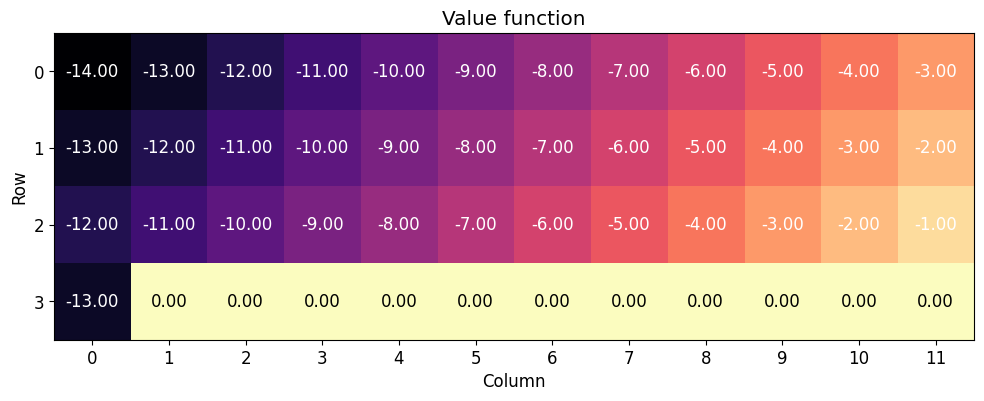

In [13]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, we write an implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
-`G` the cummulated reward during the episode

To test different scenarios you can change the code so as epsilon is constant or decaying.

In [24]:
import random

In [25]:
def update_policy(state,Q,policy):
    k=max(Q[state]) #maximum value
    indices=[j for j in range(len(Q[state])) if  Q[state][j] == k] #Get all indices where the Q[index]= maximum value
    policy[state]=np.random.choice(indices) if len(indices)>1 else indices[0]

In [26]:
def get_action(state, policy,epsilon):
    if state in policy and random.random()>epsilon:
        return policy[state]
    else:
        return random.choice(np.arange(env.action_space.n))

In [27]:
def get_sarsa(state, action, next_state,next_value,alpha, gamma,Q,reward,done):
    if not done:
        q= Q[state][action]+alpha*(reward+gamma*(Q[next_state][next_value])-Q[state][action])
    else:
        q= Q[state][action]+alpha*(reward+gamma*0-Q[state][action])
    return q

In [45]:
def sarsa(env, num_episodes, alpha, gamma=0.9,epsilon=5,drop=0.995,epsilon_min=0.005): #drop of 0.985 gives perfect results for 1st 2 rows
    # initialize action-value function (empty dictionary of arrays)
    Q=defaultdict(lambda: np.zeros(env.action_space.n))
    policy=defaultdict(lambda: 0)
    # initialize performance monitor
    J=[]
    j=0
    G=np.zeros((num_episodes,))
    for i in range(num_episodes):
        states=[]
        state=env.reset()
        action=get_action(state,policy, epsilon)
        if i%100==0:
            print("\rEpisode {}/{}".format(i, num_episodes), end="")
            sys.stdout.flush()
        while True: # for each timestep of the episode
            next_state,reward,done,info=env.step(action)
            next_action=get_action(next_state,policy, epsilon)
            G[i]+=reward
            Q[state][action]=get_sarsa(state, action, next_state, next_action,alpha, gamma,Q,reward,done)
            update_policy(state,Q,policy)
            if done:
                break
            else:
                state=next_state
                action=next_action
        #epsilon=1/(i+0.3)
    return Q,G

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default. Do not forget to modify previous function so as to test a costant or decaying epsilon.

Episode 4900/5000
Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  2  1  1  1  2  0  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  2  1  2]
 [ 0  0  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


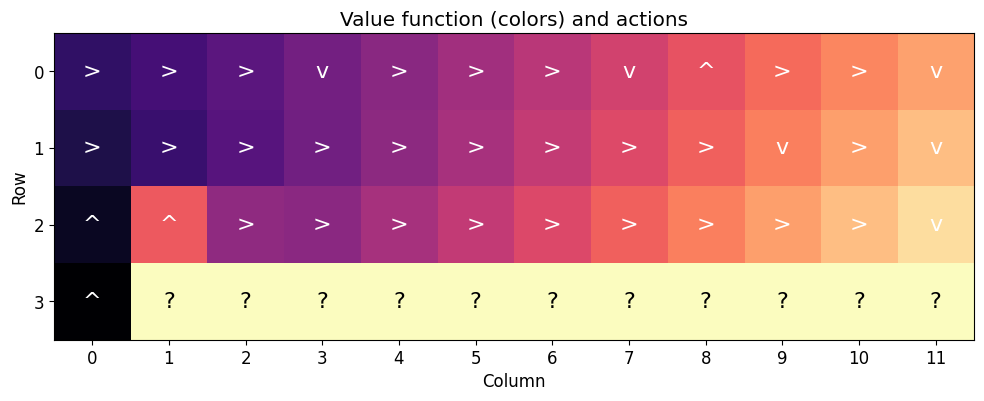

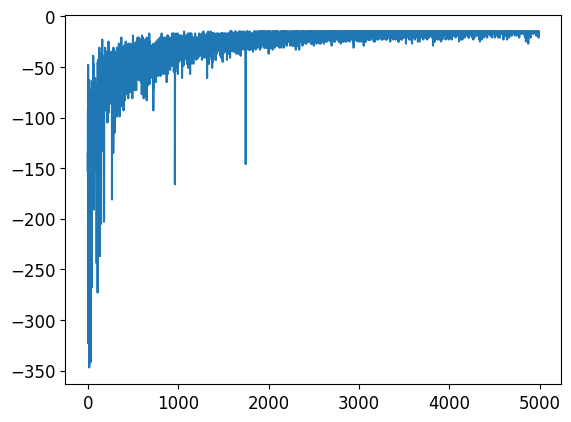

In [33]:
# obtain the estimated optimal policy and corresponding action-value function
#Q_sarsa,reward_sarsa = sarsa(env, 5000, 0.1, 1, 0.1)
Q_sarsa,reward_sarsa =sarsa(env, 5000, .01,1)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
#check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = np.array(([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])).reshape(4,12)
plot_values(V_sarsa,policy_sarsa)
plt.plot(reward_sarsa[10:-1])

<b> Key highlights: </b> <br>
    You have to be very careful about epsilon:<br>
    <ul>
     <li>max(epsilon*drop,epsilon_min) which exponentially drops epsilon may throw an error since the model starts exploiting super fast </li>
     <li>1/(i+1) that exponentially drops epsilon but again the exponential reduction in epsilon forces exploting too early </li>
     <li>Finally, a drop of 1/(i+0.3) seems adequate to reduce epsilon gradually enough
     <li> You can try your own variants

### Part 2: TD Control: Q-learning

In this section, we write an implementation of the Q-learning control algorithm.

The function has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `G` the cummulated reward during the episode

To test different scenarios you can change the code so as epsilon is constant or decaying.


In [34]:
def get_q_learning(state, action, next_state, reward, alpha, gamma, done,Q):
    if done:
        q= Q[state][action]+alpha*(reward+ 0 - Q[state][action])
    else:
        q = Q[state][action]+alpha*(reward+gamma*max(Q[next_state]) - Q[state][action])
    return q

In [46]:
def q_learning(env, num_episodes, alpha, gamma=1.0,epsilon=1):
    Q=defaultdict(lambda:np.zeros(env.action_space.n))
    policy=defaultdict(lambda:0)
    G=np.zeros((num_episodes,))
    for i in range(num_episodes):
        state=env.reset()
        action=get_action(state, policy,epsilon)
        if i%100==0:
            print("\rEpisode {}/{}".format(i, num_episodes), end="")
            sys.stdout.flush()
        epsilon=1/(0.6+i)#comment to have a constant epsilon, make sure to use a small value
        while True:
            next_state, reward, done, info = env.step(action)
            G[i]+=reward
            Q[state][action]=get_q_learning(state, action, next_state, reward, alpha, gamma, done,Q)
            update_policy(state,Q,policy)
            if done:
                break
            else:
                next_action=get_action(next_state, policy,epsilon)
                state=next_state
                action=next_action
    return Q, G

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default. Do not forget to modify previous function so as to test a costant or decaying epsilon.

Episode 4900/5000
Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  1  0  1  2  1  0  0  1  1  1  2]
 [ 1  0  1  0  1  1  1  1  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


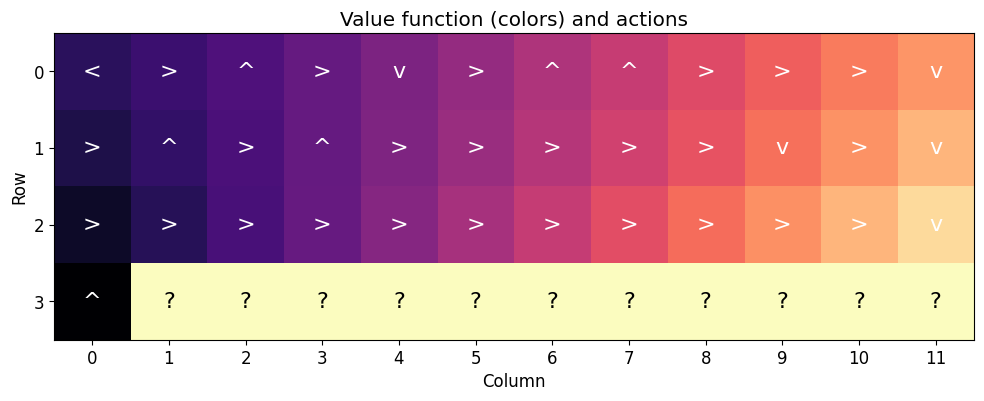

In [47]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax, reward_ql = q_learning(env, 5000, 0.1,1,0.1)
# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
#check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)
# plot the estimated optimal state-value function
V=np.array([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)]).reshape((4,12))
plot_values(V,policy_sarsamax)


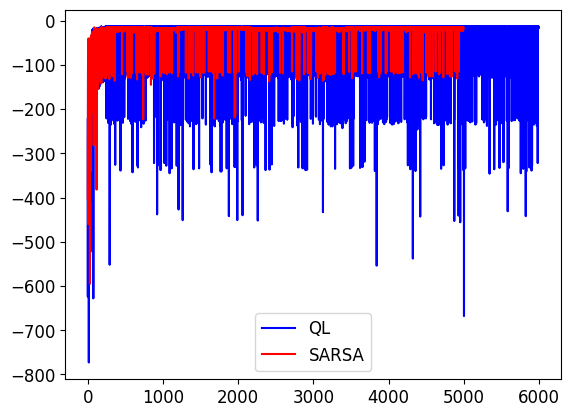

### Part 3: TD Control: Expected Sarsa

In this section, we write an implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `G` the cummulated reward during the episode

To test different scenarios you can change the code so as epsilon is constant or decaying.

In [41]:
def get_expected_sarsa(state, action, reward, next_state, Q ,done, alpha, gamma,epsilon):
    if done:
        q=Q[state][action]+alpha*(reward+0-Q[state][action])
    else:
        max_val = max(Q[next_state])*(1-epsilon+(epsilon/len(Q[state]))) #Weight the largest value with 1-e+e/|A|
        vals=np.sum(Q[next_state])*epsilon/len(Q[next_state]) + max_val  #Weight all the values by e/|A| and add them to weighted max value to return expected value
        q=Q[state][action]+alpha*(reward+gamma*vals-Q[state][action]) #get the updated value for Q[state][action] and return
    return q

In [70]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q=defaultdict(lambda: np.zeros(env.action_space.n))
    policy={}
    G=np.zeros((num_episodes,))
    # initialize performance monitor
    epsilon=1
    for i in range(num_episodes):
        #epsilon=1/(i+0.2)#comment to have a constant epsilon, make sure to use a small value
        epsilon = max(0.001, epsilon * 0.995)  # e.g., decay_rate = 0.995, epsilon_min = 0.01
        states=[] #Troubleshooting
        state=env.reset()
        if state in policy:
            action=get_action(state,policy, epsilon)
        else:
            action=env.action_space.sample()
        while True: # for each timestep of the episode
            next_state,reward,done,info=env.step(action)
            next_action = get_action(next_state, policy,epsilon) if next_state in policy.keys() else env.action_space.sample()
            Q[state][action]=get_expected_sarsa(state, action, reward, next_state, Q, done, alpha, gamma,epsilon)
            update_policy(state,Q,policy)
            G[i]+=reward
            states.append((state,action,reward,next_state))
            if done:
                break
            else:
                state=next_state
                action=next_action
    return Q, G

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default. Do not forget to modify previous function so as to test a costant or decaying epsilon.


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  0  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


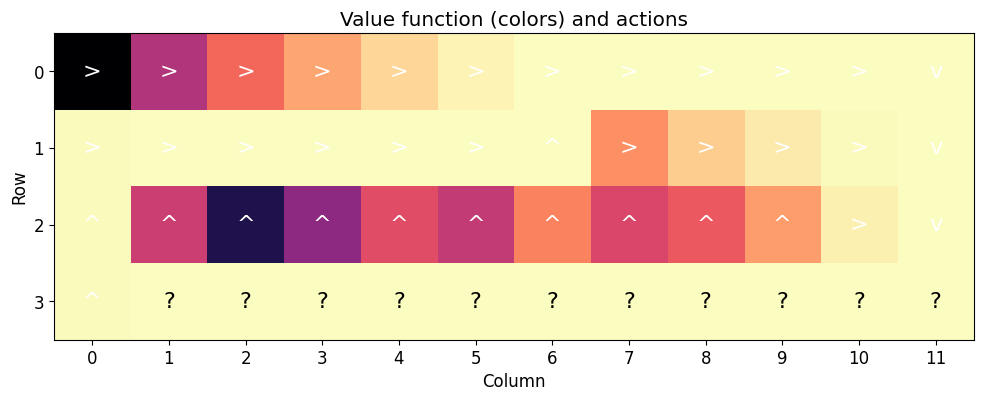

In [71]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa, reward_expsarsa = expected_sarsa(env, 5000, 0.1,1)
# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
#check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
V=np.array([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)]).reshape(4,12)
plot_values(V,policy_expsarsa)

### Part 4: Final analysis based on total reward

In this section we use results of previous sectios. Use the code below to visualize the evolution of the total reward obtained by each algorith.

What do you observe and why? How does this change with the different paramenters, in particular for constant or decaying ϵ?

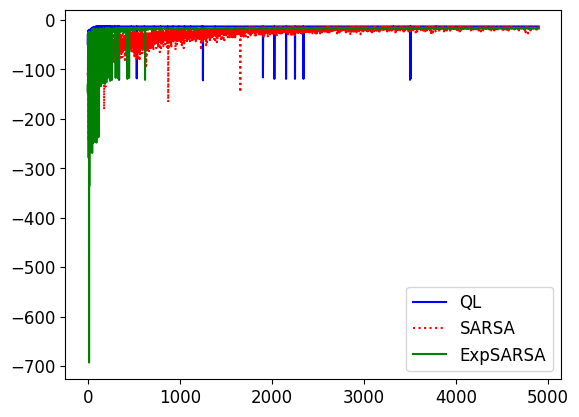

In [72]:
plt.plot(reward_ql[100:-1],color='blue', label='QL')
plt.plot(reward_sarsa[100:-1],color='red',label='SARSA', linestyle='dotted')
plt.plot(reward_expsarsa[100:-1],color='green',label='ExpSARSA')
plt.legend()
#ax2 = plt.plot(reward_sarsa,color='red', grid=True, secondary_y=True, label='Sum')